In [1]:

import networkx as nx
import numpy as np
import random, math
import graphviz

import time



import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.graph_objects as go
from pyvis.network import Network
from networkx.drawing.nx_agraph import graphviz_layout


#import pygraphviz


Jackson model
* Start with m nodes
* New nodes are introduced to m nodes
* Befriend with probability pm
* New nodes are then introduced to n of those pm nodes' connections
* Befriend with probability pn
* Continue for as many iterations as would like

Nicer version

In [32]:

# parameter selection

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

new_sim2 = JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho)

print(np.asarray(np.unique(new_sim2.helper_functions().SES_edge_classifier_all(new_sim2.graph_history[-1])[0], return_counts=True)).T)

test_graph = new_sim2.graph_history[-1]
print(nx.assortativity.attribute_assortativity_coefficient(test_graph, 'SES_High'))
'''check this
https://journals.aps.org/pre/pdf/10.1103/PhysRevE.67.026126
'''
'''WORKS FOR CORRELATION, INCORPORATE IT PROPERLY'''

plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), new_sim2, -1, layout='spring')

#nx.smallworld.sigma(test_graph, niter=10, nrand=1)


[['cross' '746']
 ['within' '2319']]
0.5122674914675767


Variying rho

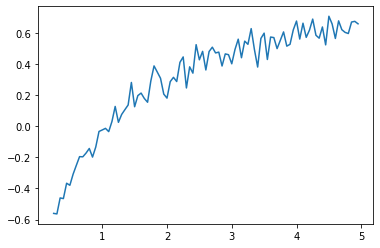

In [28]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

rho_list = np.arange(0.25, 5, 0.05)
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho_val) for rho_val in rho_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


plt.plot(rho_list, SES_assortativity_list)


Varying p

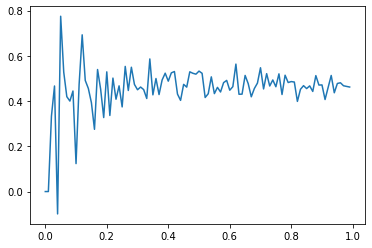

In [30]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

p_list = np.arange(0, 1, 0.01)
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o=p, n=n, pn_o=p, p_SES_high=p_SES_high, biased=True, rho=3) for p in p_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


plt.plot(p_list, SES_assortativity_list)


### Simulation version 2

Updates:
* Attributes of encountered nodes (i.e., the exposure group)
* CORRECTED: will now find parent neighbours even if not connected to parents
* Rewrtitten connection search functions to include two stages for easier access to targets/connection group

TODO
* Add connection chance as f of cross/within

In [2]:

class JacksonSimulationV2():

    def __init__(self, initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased = False, rho = 1):

        # parameters
        self.initial_n = initial_n # initial number of nodes
        self.T = T # number of iterations / final nodes - initial_n
        self.m = m # number of parent nodes encountered
        self.pm_o = pm_o # probability of befriending a parent node of same SES
        self.n = n # number of parent neighbour nodes encountered
        self.pn_o = pn_o # probability of befriending parent neighbour nodes of same SES
        self.p_SES_high = p_SES_high # probability of each node's SES to be High
        self.biased = biased # whether or not to use a class-biased simulation
        self.rho = rho # ratio (within friendship probatility)/(cross friendship probatility): rho = how many times more likely to befriend within-class than across-class (rho = 2 => twice as likely, rho = 1/3 => three times less likely)
        # NB rho is initialised as 1, hence no bias, per default. If biased, specify rho value
        
        # calculate cross-friendship probabilities: rho = po/px => px = po/rho
        self.pm_x = pm_o / rho
        self.pn_x = pn_o / rho

        if biased == True and rho == 1:
            print('Warning: Biased simulation requested, but rho = 1.')
        if biased == False and rho != 1:
            print(f'Warning: Unbiased simulation requested, but rho = {self.rho}')

        # also maybe add options for the functions used
        # self.initialiser_function = 

        # simulation memory
        self.period = 0
        self.graph_history = []
        # will also need a matrix history to make it easier to save simulations to a csv or the like

        # starting stuff
        #self.initial_nodes = [i+1 for i in range(initial_n)] # create n initial nodes, +1 for name to start at 1

        self.main()


    '''MAIN'''
    def main(self):
        # make the initial graph
        self.save_update_to_memory(self.initial_node_connector_basic())


        for t in range(self.T):
            self.update_simulation(self.graph_history[-1])



    '''INITIALISATION'''
    # basic version: all nodes get a certain number of connections
    def initial_node_connector_basic(self):
        initial_graph = nx.Graph()

        # add nodes until we have enough to start with
        while len(initial_graph.nodes) < self.initial_n:
            new_node = self.new_node_birth(initial_graph)
            initial_graph.add_nodes_from([new_node])


        #initial_graph.add_nodes_from(self.initial_nodes)

        initial_nodes = list(initial_graph.nodes)


        for node in initial_nodes:
            possible_links = initial_nodes.copy()
            possible_links.remove(node) # remove own node
            
            # randomly chooses m+n nodes without replacement from the initial nodes to connect (correction for taking the number of nodes instead if m+n>initial_n)
            initial_neighbours = list(np.random.choice(possible_links, min(self.m + self.n, self.initial_n-1), replace=False))
            
            # creates the edges
            '''for some reason it's treating this as 3 arguments?'''
            initial_edges = self.helper_functions().edge_creator_helper(node, initial_neighbours)
            initial_graph.add_edges_from(initial_edges)

        return initial_graph


    class basic_world:





        pass

    '''UPDATING'''
    # big simulation update
    def update_simulation(self, current_graph):


        # copy graph with the added connections
        new_graph = current_graph.copy()

        # add the new node
        new_node = self.new_node_birth(current_graph) # DONE
        new_graph.add_nodes_from([new_node])

        # get the connections for the new node
        parent_targets = self.find_parent_nodes_targets(self.graph_history[-1]) # DONE
        parent_neighbour_targets = self.find_parent_neighbour_targets(self.graph_history[-1], parent_targets) # DONE


        # add the exposure group of the node to its attributes
        new_node_targets = list(np.concatenate((parent_targets, parent_neighbour_targets)))
        new_node[1]['Exposure Group'].extend(new_node_targets)

        # get the connections based on the targets
        new_node_edges = self.new_node_connections(new_node, parent_targets, parent_neighbour_targets, new_graph)


        # add the connections
        new_graph.add_edges_from(new_node_edges)

        # save and update
        self.save_update_to_memory(new_graph)
        self.period += 1


    # save to history
    def save_update_to_memory(self, updated_graph):
        # save new graph to history
        '''may need to make a history for t as well, if I end up not creating new nodes every iteration'''
        self.graph_history.append(updated_graph)


    # create new node, indexed as the next number in the list
    def new_node_birth(self, graph):
        current_nodes = graph.nodes()
        new_node = max(current_nodes) + 1 if len(current_nodes) > 0 else 1

        '''currently SES determined at birth, this can be changed'''
        new_node_SES = np.random.choice([1, 0], 1, p=[self.p_SES_high, 1-self.p_SES_high])[0]

        return (new_node, {'SES_High': new_node_SES, 'Exposure Group': []})


    # find parent nodes connections
    def find_parent_nodes_targets(self, graph):
        # get the current existing nodes
        current_nodes = graph.nodes()

        # get m parent nodes
        parent_targets = np.random.choice(current_nodes, min(m, len(current_nodes)), replace=False)

        return parent_targets


    # find parent neighbour connections
    def find_parent_neighbour_targets(self, graph, parent_target_list):
        # take the list of parents and find their (unique) neighbours
        parent_neighbours = np.unique(self.helper_functions().find_neighbours(graph, parent_target_list))

        # to avoid issues: if the parents have in total less than n neighbours, take their number of neighbours instead
        n_possible_encounters = min(len(parent_neighbours), self.n)

        # get n parent neighbour nodes
        parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False)

        return parent_neighbour_targets


    # returns a list of connections to form based on targets and probabilties
    def new_node_connections(self, new_node, parent_target_list, parent_neighbour_target_list, graph):
          
        '''
        UGLY AF list comprehension: do not use but fun
        [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in [po if edge_type == 'cross' else px for edge_type in [SES_edge_classifier(G, 1, i) for i in targets]]]
        '''

        '''parents'''
        # probability pm to connect to each m of them
        # first get edge types
        parent_edge_types = [self.helper_functions().SES_edge_classifier(graph, new_node[0], i) for i in parent_target_list]
        # get list of probs depending on the probs
        parent_edge_probs = [self.pm_x if edge_type == 'cross' else self.pm_o for edge_type in parent_edge_types]
        # realised outcome per prob: vector of connections
        parent_edges = [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in parent_edge_probs]

        # realised connections: cross product of the two vectors
        parent_connections = parent_target_list * parent_edges
        parent_connections = parent_connections[parent_connections > 0] # filter out the ones with no connection

        '''parent neighbours'''
        # probability pn to connect to each n of them
        parent_neighbour_edge_types = [self.helper_functions().SES_edge_classifier(graph, new_node[0], i) for i in parent_neighbour_target_list]
        parent_neighbour_edge_probs = [self.pm_x if edge_type == 'cross' else self.pm_o for edge_type in parent_neighbour_edge_types]
        parent_neighbour_edges = [np.random.choice([0,1], size=1, p=[1-prob, prob])[0] for prob in parent_neighbour_edge_probs]

        # realised connections: cross product of the two vectors
        parent_neighbour_connections = parent_neighbour_target_list * parent_neighbour_edges
        parent_neighbour_connections = parent_neighbour_connections[parent_neighbour_connections > 0] # filter out the ones with no connection


        '''form the connections'''
        # combine the two
        new_node_connections = np.concatenate((parent_connections, parent_neighbour_connections))
        new_node_edges = self.helper_functions().edge_creator_helper(new_node[0], new_node_connections)


        return new_node_edges



    class biased_world:
        
        # new birth with SES
        def biased_node_birth(self, graph):
            current_nodes = graph.nodes()
            new_node = max(current_nodes) + 1 if len(current_nodes) > 0 else 1

            '''currently SES determined at birth, this can be changed'''
            new_node_SES = np.random.choice(['High', 'Low'], 1, p=[self.p_SES_high, 1-self.p_SES_high])[0]

            return (new_node, {'SES': new_node_SES})



        # find parent connections

        pass






    class helper_functions:
        '''useful functions'''
        # return the indicated attribute for a list of nodes
        def get_select_node_attributes(self, graph, attribute, node_list):
            attribute_dict_all_nodes = nx.get_node_attributes(graph, attribute)
            attribute_dict = {node: attribute_dict_all_nodes[node] for node in node_list}

            return attribute_dict

        # creates a list of edges based on targets 
        def edge_creator_helper(self, node, connection_targets):
            edges = [(node, connection_target) for connection_target in connection_targets]

            return edges

        # returns list of neighbours for all the nodes in the given list
        def find_neighbours(self, graph, node_list):
            if len(node_list) != 0:
                all_neighbours_list = np.concatenate(([list(graph[node]) for node in node_list]))
            else:
                all_neighbours_list = []

            return all_neighbours_list

        
        # check connection type of two connected nodes: cross(-class) or within(-class)
        def SES_edge_classifier(self, graph, node1, node2):
            SES_values = list(self.get_select_node_attributes(graph, 'SES_High', [node1, node2]).values())
            link_type = 'within' if SES_values[0] == SES_values[1] else 'cross'

            return link_type

        # same, but now for all edges
        def SES_edge_classifier_all(self, graph):
            edges = graph.edges()

            list_edge_type = [self.SES_edge_classifier(graph, edge[0], edge[1]) for edge in edges]

            dict_edge_type = dict(zip(edges, list_edge_type))
            dict_edge_type = {edge: {'Edge type': dict_edge_type[edge]} for edge in edges}

            return list_edge_type, dict_edge_type




### NX drawing

In [ ]:


class sim_drawing(object):

    # can make a general one later
    def color_scale_from_attr(self, attr):


        return color_scale

    # assigns colour red if low SES, blue if high
    # NB: assumes that nodes are given in same order as when drawing
    def color_scale_SES(self, simulation, t=-1):
        SES_list = list(nx.get_node_attributes(simulation.graph_history[t], 'SES_High').values())
        color_scale_SES = ['blue' if SES == 'High' else 'red' for SES in SES_list]

        return color_scale_SES


    # kamada kawai network
    def draw_kamada_kawai(self, simulation, t=-1, color_scale = None):
        fig = plt.figure()

        title_suffix = simulation.period if t == -1 else t
        plt.title(f"Network Graph, t={title_suffix}")

        if color_scale == 'SES':
            cmap = self.color_scale_SES(simulation, t)
            nx.draw(simulation.graph_history[t], node_color = cmap, node_size = 10, cmap = cmap)

        else:
            nx.draw(simulation.graph_history[t], node_size = 10, cmap = cmap)


        plt.close()
        return fig












### Plotly drawing

In [3]:

class plotly_sim_drawing(object):
    '''HELPER FUNCTIONS'''
    '''MODIFY THESE TO TAKE A SPECIFIC TIME INSTEAD'''
    # gets a tuple of arrays of edge positions
    def go_get_edge_positions(self, graph, graph_layout):

        edge_x = []
        edge_y = []

        for edge in graph.edges():
            x0, y0 = graph_layout[edge[0]]
            x1, y1 = graph_layout[edge[1]]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)


        return (edge_x, edge_y)


    # gets a edge trace based on a wanted layout and graph
    #to add color list later: https://stackoverflow.com/questions/62601052/option-to-add-edge-colouring-in-networkx-trace-using-plotly

    def go_get_edge_trace(self, graph, graph_layout):#, edge_color_list):
        edge_x, edge_y = self.go_get_edge_positions(graph, graph_layout)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            hoverinfo=None,
            mode='lines',

            line=dict(
                width=0.5, 
                color='#888')
        )

        return edge_trace

    # returns a tuple with an array for each of x pos and y pos
    def go_get_node_positions(self, graph, graph_layout):

        node_x_list = []
        node_y_list = []

        for node in graph.nodes():
            node_x, node_y = graph_layout[node]
            node_x_list.append(node_x)
            node_y_list.append(node_y)


        return (node_x_list, node_y_list)


    # gets a node trace based on a wanted layout and graph
    def go_get_node_trace(self, graph, graph_layout, node_color_list, node_text):
        node_x, node_y = self.go_get_node_positions(graph, graph_layout)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            hoverinfo='text',
            mode='markers',
            text=node_text,
            #IDEA: add text for number of friends in each group

            marker=dict(
                size=5,
                color=node_color_list),
        )

        return node_trace


    '''ACTUAL DRAWINGS'''

    # basic plotly draw
    def plotly_draw(self, simulation, t=-1, layout='spring'):
        graph = simulation.graph_history[t]
        SES_list = list(simulation.helper_functions().get_select_node_attributes(graph, 'SES_High', graph.nodes()).values())
        SES_color_list = ['blue' if SES == 1 else 'red' for SES in SES_list]


        # texts
        node_text = [str(i) + '_' + str(j) for i, j in zip(list(graph.nodes()), SES_list)]

        graph_layout = nx.spring_layout(graph, seed=42, scale=10) if layout =='spring' else nx.random_layout(graph)

        edge_trace = self.go_get_edge_trace(graph, graph_layout)
        node_trace = self.go_get_node_trace(graph, graph_layout, SES_color_list, node_text)


        fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'<br>Network graph, t={t}',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                        )


        return fig



### Simulation version 1

Errors:
* Does not find parent neighbours if not connected to parent

In [ ]:

class JacksonSimulation():

    def __init__(self, initial_n, T, m, pm, n, pn, p_SES_high):

        # parameters
        self.initial_n = initial_n
        self.T = T
        self.m = m
        self.pm = pm
        self.n = n
        self.pn = pn
        self.p_SES_high = p_SES_high # random for now, could be determined by the parent nodes

        # also maybe add options for the functions used
        # self.initialiser_function = 

        # simulation memory
        self.period = 0
        self.graph_history = []
        # will also need a matrix history to make it easier to save simulations to a csv or the like

        # starting stuff
        #self.initial_nodes = [i+1 for i in range(initial_n)] # create n initial nodes, +1 for name to start at 1

        self.main()


    '''MAIN'''
    def main(self):
        # make the initial graph
        self.save_update_to_memory(self.initial_node_connector_basic())


        for t in range(self.T):
            self.update_simulation(self.graph_history[-1])



    '''INITIALISATION'''
    # basic version: all nodes get a certain number of connections
    def initial_node_connector_basic(self):
        initial_graph = nx.Graph()

        # add nodes until we have enough to start with
        while len(initial_graph.nodes) < self.initial_n:
            new_node = self.new_node_birth(initial_graph)
            initial_graph.add_nodes_from([new_node])


        #initial_graph.add_nodes_from(self.initial_nodes)

        initial_nodes = list(initial_graph.nodes)


        for node in initial_nodes:
            possible_links = initial_nodes.copy()
            possible_links.remove(node) # remove own node
            
            # randomly chooses m+n nodes without replacement from the initial nodes to connect (correction for taking the number of nodes instead if m+n>initial_n)
            initial_neighbours = list(np.random.choice(possible_links, min(self.m + self.n, self.initial_n-1), replace=False))

            # creates the edges
            initial_edges = self.helper_functions().edge_creator_helper(node, initial_neighbours)
            initial_graph.add_edges_from(initial_edges)

        return initial_graph


    class basic_world:





        pass

    '''UPDATING'''
    # big simulation update
    def update_simulation(self, current_graph):

        # add the new node
        new_node = self.new_node_birth(current_graph) # DONE

        # get the connections for the new node
        parent_connections = self.find_parent_nodes_connections(current_graph) # DONE
        parent_neighbour_connections = self.find_parent_neighbour_connections(current_graph, parent_connections) # DONE
             
        # combine the two
        new_node_connections = np.concatenate((parent_connections, parent_neighbour_connections))
        new_node_edges = self.helper_functions().edge_creator_helper(new_node[0], new_node_connections)

        # copy graph with the added connections
        new_graph = current_graph.copy()

        new_graph.add_nodes_from([new_node]) #issue is here
        new_graph.add_edges_from(new_node_edges)

        self.save_update_to_memory(new_graph)
        self.period += 1


    # save to history
    def save_update_to_memory(self, updated_graph):
        # save new graph to history
        '''may need to make a history for t as well, if I end up not creating new nodes every iteration'''
        self.graph_history.append(updated_graph)


    # create new node, indexed as the next number in the list
    def new_node_birth(self, graph):
        current_nodes = graph.nodes()
        new_node = max(current_nodes) + 1 if len(current_nodes) > 0 else 1

        '''currently SES determined at birth, this can be changed'''
        new_node_SES = np.random.choice(['High', 'Low'], 1, p=[self.p_SES_high, 1-self.p_SES_high])[0]

        return (new_node, {'SES': new_node_SES})


    # find parent nodes connections
    def find_parent_nodes_connections(self, graph):
        # get the current existing nodes
        current_nodes = graph.nodes()

        # get m parent nodes
        parent_targets = np.random.choice(current_nodes, m, replace=False)

        # probability pm to connect to each m of them
        parents_edge_chance = np.random.choice([0,1], size=self.m, p=[1-self.pm, self.pm])

        # realised connections: cross product of the two vectors
        parent_connections = parent_targets * parents_edge_chance
        parent_connections = parent_connections[parent_connections > 0] # filter out the ones with no connection

        return parent_connections

    # find parent neighbour connections
    def find_parent_neighbour_connections(self, graph, parent_connections_list):
        # take the list of parents and find their (unique) neighbours
        parent_neighbours = np.unique(self.helper_functions().find_neighbours(graph, parent_connections_list))

        # to avoid issues: if the parents have in total less than n neighbours, take their number of neighbours instead
        n_possible_encounters = min(len(parent_neighbours), self.n)

        # get n parent neighbour nodes
        parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False)

        # probability pn to connect to each n of them
        parent_neighbours_edge_chance = np.random.choice([0,1], size = n_possible_encounters, p = (1-self.pn, self.pn))

        # realised connections: cross product of the two vectors
        parent_neighbours_connections = parent_neighbour_targets * parent_neighbours_edge_chance
        parent_neighbours_connections = parent_neighbours_connections[parent_neighbours_connections > 0] # filter out the ones with no connection


        return parent_neighbours_connections



    class biased_world:
        
        # new birth with SES
        def biased_node_birth(self, graph):
            current_nodes = graph.nodes()
            new_node = max(current_nodes) + 1 if len(current_nodes) > 0 else 1

            '''currently SES determined at birth, this can be changed'''
            new_node_SES = np.random.choice(['High', 'Low'], 1, p=[self.p_SES_high, 1-self.p_SES_high])[0]

            return (new_node, {'SES': new_node_SES})



        # find parent connections








        pass






    class helper_functions:
        '''useful functions'''
        # return the indicated attribute for a list of nodes
        def get_select_node_attributes(self, graph, attribute, node_list):
            attribute_dict_all_nodes = nx.get_node_attributes(graph, attribute)
            attribute_dict = {node: attribute_dict_all_nodes[node] for node in node_list}

            return attribute_dict

        # creates a list of edges based on targets 
        def edge_creator_helper(self, node, connection_targets):
            edges = [(node, connection_target) for connection_target in connection_targets]

            return edges

        # returns list of neighbours for all the nodes in the given list
        def find_neighbours(self, graph, node_list):
            if len(node_list) != 0:
                all_neighbours_list = np.concatenate(([list(graph[node]) for node in node_list]))
            else:
                all_neighbours_list = []

            return all_neighbours_list

        
        # check connection type of two connected nodes: cross(-class) or within(-class)
        def SES_edge_classifier(self, graph, node1, node2):    
            SES_values = list(self.get_select_node_attributes(graph, 'SES', [node1, node2]).values())
            link_type = 'within' if SES_values[0] == SES_values[1] else 'cross'

            return link_type

        # same, but now for all edges
        def SES_edge_classifier_all(self, graph):
            edges = graph.edges()

            list_edge_type = [self.SES_edge_classifier(graph, edge[0], edge[1]) for edge in edges]

            return list_edge_type


